<a href="https://colab.research.google.com/github/NateMophi/SCC-454/blob/main/LAB2/SCC454_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark==4.0.0 -q

# Java Installation
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jre-headless_11.0.29%2b7-1ubuntu1%7e22.04_amd64.deb  404  Not Found [IP: 91.189.92.22 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jdk-headless_11.0.29%2b7-1ubuntu1%7e22.04_amd64.deb  404  Not Found [IP: 91.189.92.22 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [ ]:
# Set Java environmenr variable
import os
os.environ["JAVA HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

print("PySpark & Java installed successfully!")

PySpark & Java installed successfully!


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

# Session Creation
spark = SparkSession.builder.appName("SCC454-SparkIntro").config("spark.driver.memory", "4g")\
        .config("spark.ui.port", "4050")\
        .getOrCreate()

  # Underlying Context
sc = spark.sparkContext
print(f"Spark Version: {spark.version}")
print(f"Spark App Name: {spark.sparkContext.appName}")
print(f"Master: {spark.sparkContext.master}")

Spark Version: 4.0.0
Spark App Name: SCC454-SparkIntro
Master: local[*]


# **Resilient Distributed Datasets (RDDs)**

In [ ]:
# RDD Creation

# 1a) Parallelization from a Python Collection
nums = [1,2,3,4,5,6,7,8,9,10]
nums_rdd =sc.parallelize(nums)

type(nums_rdd)
print(f"Number of paritions: {nums_rdd.getNumPartitions()}")
print(f"First 5 elements : {nums_rdd.take(5)}")



Number of paritions: 2
First 5 elements : [1, 2, 3, 4, 5]


In [ ]:
# 1b) Parallelize with a specific number of partitions
nums_rdd_4part = sc.parallelize(nums, 4)
print(f"Number of partitions: {nums_rdd_4part.getNumPartitions()}")

# View Partitions
print("\nData in each partition: ")
print(nums_rdd_4part.glom().collect())

Number of partitions: 4

Data in each partition: 
[[1, 2], [3, 4], [5, 6], [7, 8, 9, 10]]


In [ ]:
# 2) Create RDD from text file
sample_text = """Apache Spark is a unified analytics engine for large-scale data processing.
It provides high-level APIs in Java, Scala, Python and R.
Spark powers a stack of libraries including SQL and DataFrames.
It also includes MLlib for machine learning and GraphX for graph processing.
Spark can run on Hadoop, Apache Mesos, Kubernetes, standalone, or in the cloud."""


with open("spark_intro.txt", "w") as f:
  f.write(sample_text)

# Load text file as RDD
text_rdd = sc.textFile("spark_intro.txt")
print(f"Number of lines: {text_rdd.count()}")
print("\n1st 3 lines:")
for line in text_rdd.take(3):
  print(f" - {line}")

Number of lines: 5

1st 3 lines:
 - Apache Spark is a unified analytics engine for large-scale data processing.
 - It provides high-level APIs in Java, Scala, Python and R.
 - Spark powers a stack of libraries including SQL and DataFrames.


## 2.3 Transformations and Actions

RDD operations are divided into two categories:

**Transformations**: Create a new RDD from an existing one. They are *lazy* - they don't execute until an action is called.

| Transformation | Description |
|----------------|-------------|
| `map(func)` | Apply function to each element |
| `filter(func)` | Keep elements where function returns true |
| `flatMap(func)` | Map then flatten the results |
| `distinct()` | Remove duplicates |
| `reduceByKey(func)` | Aggregate values by key |
| `groupByKey()` | Group values by key |
| `sortBy(func)` | Sort RDD elements |

**Actions**: Return a value to the driver program. They *trigger* the execution of transformations.

| Action | Description |
|--------|-------------|
| `collect()` | Return all elements as a list |
| `count()` | Return the number of elements |
| `first()` | Return the first element |
| `take(n)` | Return first n elements |
| `reduce(func)` | Aggregate elements using a function |
| `saveAsTextFile(path)` | Write elements to a text file |

In [ ]:
numbers = sc.parallelize(range(1,11))

# map: Apply function to each element
squared = numbers.map(lambda x: x**2)
print(f"Original: {numbers.collect()} ")
print(f"Squared: {squared.collect()} ")

# filter: Keep Only elements that match a condition
evens = numbers.filter(lambda x: x%2==0)
print(f"Evens: {evens.collect()} ")

# Chaining transformation
even_squares = numbers.filter(lambda x: x%2==0).map(lambda x: x**2)
print(f"Even squares: {even_squares}")




Original: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
Squared: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100] 
Evens: [2, 4, 6, 8, 10] 


In [ ]:
# flatMap: map then Flatten
sentences = sc.parallelize(["Hello World", "Apache Spark", "Big Data"])

# map vs flatmap
words_map = sentences.map(lambda s: s.split())
words_flatmap = sentences.flatMap(lambda s: s.split())

print(f"Using map:     {words_map.collect()}")
print(f"Using flatMap: {words_flatmap.collect()}")

Using map:     [['Hello', 'World'], ['Apache', 'Spark'], ['Big', 'Data']]
Using flatMap: ['Hello', 'World', 'Apache', 'Spark', 'Big', 'Data']


In [ ]:
sentences

ParallelCollectionRDD[13] at readRDDFromFile at PythonRDD.scala:297

In [ ]:
# Action Examples

numbers = sc.parallelize([1, 2, 3, 4, 5])

print(f"collect(): {numbers.collect()}")
print(f"count():   {numbers.count()}")
print(f"first():   {numbers.first()}")
print(f"take(3):   {numbers.take(3)}")
print(f"sum():     {numbers.sum()}")
print(f"mean():    {numbers.mean()}")
print(f"max():     {numbers.max()}")
print(f"min():     {numbers.min()}")

# reduce: Aggregate elements
total = numbers.reduce(lambda a, b: a + b)
print(f"reduce(+): {total}")

collect(): [1, 2, 3, 4, 5]
count():   5
first():   1
take(3):   [1, 2, 3]
sum():     15
mean():    3.0
max():     5
min():     1
reduce(+): 15


## 2.4 Lazy Evaluation

Spark transformations are *lazy* - they don't execute immediately. Instead, Spark builds up a *lineage graph* (DAG - Directed Acyclic Graph) of transformations. The actual computation only happens when an action is called.

**Benefits of Lazy Evaluation:**
- Allows Spark to optimize the execution plan
- Reduces unnecessary computations
- Enables fault tolerance through lineage

In [ ]:
# Demonstrating Lazy Evaluation
import time

# Create an RDD and apply transformations
print("Creating RDD and transformations...")
start = time.time()

large_rdd = sc.parallelize(range(1000000))
transformed = large_rdd.map(lambda x: x * 2).filter(lambda x: x % 4 == 0)

print(f"Time to define transformations: {time.time() - start:.4f} seconds")
print(f"Transformations are defined but NOT executed yet!")
print(f"Type of 'transformed': {type(transformed)}")

# Now trigger execution with an action
print("\nCalling count() action...")
start = time.time()
result = transformed.count()
print(f"Time to execute: {time.time() - start:.4f} seconds")
print(f"Count: {result}")

Creating RDD and transformations...
Time to define transformations: 0.0061 seconds
Transformations are defined but NOT executed yet!
Type of 'transformed': <class 'pyspark.core.rdd.PipelinedRDD'>

Calling count() action...
Time to execute: 1.1921 seconds
Count: 500000


## 2.5 Word Count Example - The "Hello World" of Big Data

Word Count is the classic MapReduce example. Let's implement it using Spark RDDs.

In [ ]:
# Create a sample text
text = """Spark is fast and general purpose cluster computing system
Spark provides high level APIs in Java Scala Python and R
Spark supports general computation graphs for data analysis
Spark has rich set of higher level tools including Spark SQL
Spark SQL provides support for structured data processing"""

# Save to file
with open("wordcount_input.txt", "w") as f:
    f.write(text)

In [ ]:
# Word Count using RDDs - Step by Step
lines = sc.textFile("wordcount_input.txt")

# Step 1: Split each line into words
words = lines.flatMap(lambda line: line.lower().split())
print("Step 1 - Words:")
print(words.take(10))

# Step 2: Map each word to a (word, 1) pair
word_pairs = words.map(lambda word: (word, 1))
print("\nStep 2 - Word pairs:")
print(word_pairs.take(10))

# Step 3: Reduce by key - sum up counts for each word
word_counts = word_pairs.reduceByKey(lambda a, b: a + b)
print("\nStep 3 - Word counts:")
print(word_counts.take(10))

# Step 4: Sort by count (descending)
sorted_counts = word_counts.sortBy(lambda x: -x[1])
print("\nTop 10 words:")
for word, count in sorted_counts.take(10):
    print(f"  {word}: {count}")

Step 1 - Words:
['spark', 'is', 'fast', 'and', 'general', 'purpose', 'cluster', 'computing', 'system', 'spark']

Step 2 - Word pairs:
[('spark', 1), ('is', 1), ('fast', 1), ('and', 1), ('general', 1), ('purpose', 1), ('cluster', 1), ('computing', 1), ('system', 1), ('spark', 1)]

Step 3 - Word counts:
[('fast', 1), ('and', 2), ('general', 2), ('computing', 1), ('high', 1), ('level', 2), ('java', 1), ('python', 1), ('supports', 1), ('for', 2)]

Top 10 words:
  spark: 6
  and: 2
  general: 2
  level: 2
  for: 2
  provides: 2
  data: 2
  sql: 2
  fast: 1
  computing: 1


In [ ]:
# Word Count - Concise Version (one-liner)

word_counts_concise = sc.textFile("wordcount_input.txt") \
    .flatMap(lambda line: line.lower().split()) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: -x[1])

print("Word counts (concise version):")
for word, count in word_counts_concise.take(10):
    print(f"  {word}: {count}")

Word counts (concise version):
  spark: 6
  and: 2
  general: 2
  level: 2
  for: 2
  provides: 2
  data: 2
  sql: 2
  fast: 1
  computing: 1


---
# Part 3: Spark DataFrames
---

## 3.1 Introduction to DataFrames

A DataFrame is a distributed collection of data organized into named columns, similar to a table in a relational database or a DataFrame in pandas. DataFrames are built on top of RDDs but provide:

- **Schema**: Named columns with data types
- **Optimized Execution**: Catalyst optimizer for query optimization
- **Familiar API**: SQL-like operations

**DataFrames vs RDDs:**

| Feature | RDD | DataFrame |
|---------|-----|----------|
| Schema | No schema | Named columns with types |
| Optimization | No automatic optimization | Catalyst optimizer |
| Ease of use | Low-level API | High-level, SQL-like API |
| Performance | Good | Better (optimized) |
| Data types | Any Python object | Structured data types |

## 3.2 Creating DataFrames

There are multiple ways to create DataFrames in Spark.

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import Row

# Method 1: From a list of tuples
data = [
    ("Alice", 28, "Data Scientist", 75000),
    ("Bob", 35, "Software Engineer", 85000),
    ("Charlie", 32, "Data Analyst", 65000),
    ("Diana", 29, "ML Engineer", 90000),
    ("Eve", 41, "Data Scientist", 95000)
]
columns = ["name", "age", "role", "salary"]

df = spark.createDataFrame(data, columns)
df.show()


+-------+---+-----------------+------+
|   name|age|             role|salary|
+-------+---+-----------------+------+
|  Alice| 28|   Data Scientist| 75000|
|    Bob| 35|Software Engineer| 85000|
|Charlie| 32|     Data Analyst| 65000|
|  Diana| 29|      ML Engineer| 90000|
|    Eve| 41|   Data Scientist| 95000|
+-------+---+-----------------+------+



In [ ]:
# Method 2: With explicit schema
schema = StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("role", StringType(), True),
    StructField("salary", IntegerType(), True)
])

df_with_schema = spark.createDataFrame(data, schema)
df_with_schema.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- role: string (nullable = true)
 |-- salary: integer (nullable = true)



In [ ]:
# Method 3: From a pandas DataFrame
import pandas as pd

pandas_df = pd.DataFrame({
    "city": ["London", "Manchester", "Birmingham", "Leeds", "Glasgow"],
    "population": [8982000, 547627, 1141816, 793139, 626410],
    "country": ["England", "England", "England", "England", "Scotland"]
})

spark_df = spark.createDataFrame(pandas_df)
spark_df.show()

+----------+----------+--------+
|      city|population| country|
+----------+----------+--------+
|    London|   8982000| England|
|Manchester|    547627| England|
|Birmingham|   1141816| England|
|     Leeds|    793139| England|
|   Glasgow|    626410|Scotland|
+----------+----------+--------+



In [ ]:
# Method 4: From Row objects
row_data = [
    Row(product="Laptop", price=999.99, quantity=50),
    Row(product="Mouse", price=29.99, quantity=200),
    Row(product="Keyboard", price=79.99, quantity=150)
]

df_rows = spark.createDataFrame(row_data)
df_rows.show()

+--------+------+--------+
| product| price|quantity|
+--------+------+--------+
|  Laptop|999.99|      50|
|   Mouse| 29.99|     200|
|Keyboard| 79.99|     150|
+--------+------+--------+



## 3.3 Loading Data from External Sources

Spark can read data from various formats including CSV, JSON, Parquet, and more. Let's download a real-world dataset to work with.

In [ ]:
# Download the Global Land Temperatures dataset from NASA GISS
# This is the official GISTEMP v4 dataset (Global Land-Ocean Temperature Index)

!wget -q https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv -O global_temp.csv

# Preview the file
!head -15 global_temp.csv

Land-Ocean: Global Means
Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880,-.19,-.25,-.10,-.17,-.11,-.22,-.19,-.11,-.15,-.24,-.23,-.18,-.18,***,***,-.13,-.17,-.21
1881,-.20,-.15,.03,.04,.05,-.19,.00,-.04,-.16,-.22,-.19,-.07,-.09,-.10,-.18,.04,-.08,-.19
1882,.15,.13,.04,-.17,-.15,-.23,-.17,-.08,-.15,-.24,-.17,-.36,-.12,-.09,.07,-.09,-.16,-.19
1883,-.30,-.37,-.13,-.18,-.17,-.08,-.07,-.14,-.21,-.11,-.23,-.11,-.18,-.20,-.34,-.16,-.10,-.19
1884,-.13,-.08,-.36,-.41,-.34,-.36,-.30,-.27,-.27,-.25,-.34,-.31,-.29,-.27,-.11,-.37,-.31,-.29
1885,-.59,-.34,-.27,-.42,-.46,-.44,-.34,-.32,-.29,-.24,-.24,-.11,-.34,-.35,-.41,-.38,-.37,-.26
1886,-.44,-.51,-.43,-.29,-.25,-.35,-.19,-.31,-.24,-.28,-.28,-.25,-.32,-.31,-.36,-.32,-.28,-.27
1887,-.73,-.58,-.36,-.36,-.31,-.25,-.26,-.36,-.26,-.36,-.26,-.34,-.37,-.36,-.52,-.34,-.29,-.29
1888,-.34,-.36,-.41,-.21,-.22,-.17,-.11,-.16,-.12,.01,.02,-.05,-.18,-.20,-.35,-.28,-.15,-.03
1889,-.10,.16,.06,.09,-.01,-.10,-.07,-.20,-.24,-.26,-.34

In [ ]:
# Simpler approach: use pandas to clean, then convert to Spark
import pandas as pd
from pyspark.sql.functions import col, lit, explode, array, struct

# Read with pandas, skip the first row
pdf = pd.read_csv("global_temp.csv", skiprows=1)
print("Pandas columns:", pdf.columns.tolist())
print(pdf.head())

# Convert to Spark DataFrame
temp_df_raw = spark.createDataFrame(pdf)

print("\nSpark DataFrame:")
temp_df_raw.show(5)
print("\nSchema:")
temp_df_raw.printSchema()

# Now transform to long format
month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

temp_df = temp_df_raw.select(
    col("Year"),
    explode(array([struct(lit(i+1).alias("Month"), col(m).cast("double").alias("Mean"))
                   for i, m in enumerate(month_cols)])).alias("data")
).select(
    col("Year").cast("int").alias("Year"),
    col("data.Month").alias("Month"),
    col("data.Mean").alias("Mean")
).filter(col("Mean").isNotNull())

# Add a Source column for consistency
temp_df = temp_df.withColumn("Source", lit("GISTEMP"))

print("\nTransformed data (long format):")
temp_df.show(10)

print("\nSchema:")
temp_df.printSchema()

print(f"\nTotal records: {temp_df.count()}")

Pandas columns: ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']
   Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1880 -0.19 -0.25 -0.10 -0.17 -0.11 -0.22 -0.19 -0.11 -0.15 -0.24 -0.23   
1  1881 -0.20 -0.15  0.03  0.04  0.05 -0.19  0.00 -0.04 -0.16 -0.22 -0.19   
2  1882  0.15  0.13  0.04 -0.17 -0.15 -0.23 -0.17 -0.08 -0.15 -0.24 -0.17   
3  1883 -0.30 -0.37 -0.13 -0.18 -0.17 -0.08 -0.07 -0.14 -0.21 -0.11 -0.23   
4  1884 -0.13 -0.08 -0.36 -0.41 -0.34 -0.36 -0.30 -0.27 -0.27 -0.25 -0.34   

    Dec   J-D   D-N   DJF   MAM   JJA   SON  
0 -0.18 -0.18   ***   *** -0.13 -0.17 -0.21  
1 -0.07 -0.09  -.10  -.18  0.04 -0.08 -0.19  
2 -0.36 -0.12  -.09   .07 -0.09 -0.16 -0.19  
3 -0.11 -0.18  -.20  -.34 -0.16 -0.10 -0.19  
4 -0.31 -0.29  -.27  -.11 -0.37 -0.31 -0.29  

Spark DataFrame:
+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+---

## 3.4 DataFrame Operations

DataFrames support a rich set of operations for data manipulation and analysis.

In [ ]:
from pyspark.sql.functions import col, year, month, avg, max, min, count, round

# Select columns
print("Select specific columns:")
temp_df.select("Year", "Month", "Mean").show(5)

# Select with expressions - convert to Fahrenheit
print("\nSelect with expressions (add Fahrenheit):")
temp_df.select(
    col("Year"),
    col("Month"),
    col("Mean"),
    round(col("Mean") * 1.8 + 32, 2).alias("Mean_Fahrenheit")
).show(5)

Select specific columns:
+----+-----+-----+
|Year|Month| Mean|
+----+-----+-----+
|1880|    1|-0.19|
|1880|    2|-0.25|
|1880|    3| -0.1|
|1880|    4|-0.17|
|1880|    5|-0.11|
+----+-----+-----+
only showing top 5 rows

Select with expressions (add Fahrenheit):
+----+-----+-----+---------------+
|Year|Month| Mean|Mean_Fahrenheit|
+----+-----+-----+---------------+
|1880|    1|-0.19|          31.66|
|1880|    2|-0.25|          31.55|
|1880|    3| -0.1|          31.82|
|1880|    4|-0.17|          31.69|
|1880|    5|-0.11|           31.8|
+----+-----+-----+---------------+
only showing top 5 rows


In [ ]:
# Filter rows
print("Filter: Temperatures above 0.5°C anomaly:")
temp_df.filter(col("Mean") > 0.5).show(5)

# Multiple conditions
print("\nFilter: Year 2020 or later with mean > 0.8:")
temp_df.filter(
    (col("Year") >= 2020) & (col("Mean") > 0.8)
).show(10)

Filter: Temperatures above 0.5°C anomaly:
+----+-----+----+-------+
|Year|Month|Mean| Source|
+----+-----+----+-------+
|1981|    1|0.53|GISTEMP|
|1983|    1|0.53|GISTEMP|
|1988|    1|0.57|GISTEMP|
|1988|    3|0.52|GISTEMP|
|1990|    3| 0.8|GISTEMP|
+----+-----+----+-------+
only showing top 5 rows

Filter: Year 2020 or later with mean > 0.8:
+----+-----+----+-------+
|Year|Month|Mean| Source|
+----+-----+----+-------+
|2020|    1|1.18|GISTEMP|
|2020|    2|1.24|GISTEMP|
|2020|    3|1.18|GISTEMP|
|2020|    4|1.12|GISTEMP|
|2020|    5|0.99|GISTEMP|
|2020|    6|0.91|GISTEMP|
|2020|    7|0.89|GISTEMP|
|2020|    8|0.86|GISTEMP|
|2020|    9|0.97|GISTEMP|
|2020|   10|0.87|GISTEMP|
+----+-----+----+-------+
only showing top 10 rows


In [ ]:
# Add new columns with withColumn
from pyspark.sql.functions import when

# The data already has Year and Month columns, let's add derived columns
temp_df_enhanced = temp_df \
    .withColumn("Mean_F", round(col("Mean") * 1.8 + 32, 2)) \
    .withColumn("Decade", (col("Year") / 10).cast("int") * 10) \
    .withColumn("Season",
                when(col("Month").isin(12, 1, 2), "Winter")
                .when(col("Month").isin(3, 4, 5), "Spring")
                .when(col("Month").isin(6, 7, 8), "Summer")
                .otherwise("Autumn"))

temp_df_enhanced.show(10)

+----+-----+-----+-------+------+------+------+
|Year|Month| Mean| Source|Mean_F|Decade|Season|
+----+-----+-----+-------+------+------+------+
|1880|    1|-0.19|GISTEMP| 31.66|  1880|Winter|
|1880|    2|-0.25|GISTEMP| 31.55|  1880|Winter|
|1880|    3| -0.1|GISTEMP| 31.82|  1880|Spring|
|1880|    4|-0.17|GISTEMP| 31.69|  1880|Spring|
|1880|    5|-0.11|GISTEMP|  31.8|  1880|Spring|
|1880|    6|-0.22|GISTEMP|  31.6|  1880|Summer|
|1880|    7|-0.19|GISTEMP| 31.66|  1880|Summer|
|1880|    8|-0.11|GISTEMP|  31.8|  1880|Summer|
|1880|    9|-0.15|GISTEMP| 31.73|  1880|Autumn|
|1880|   10|-0.24|GISTEMP| 31.57|  1880|Autumn|
+----+-----+-----+-------+------+------+------+
only showing top 10 rows


In [ ]:
# Sorting
print("Sorted by Mean (descending) - Warmest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").desc()).show(10)

print("\nSorted by Mean (ascending) - Coldest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").asc()).show(10)

Sorted by Mean (descending) - Warmest temperature anomalies:
+----+-----+----+-------+------+------+------+
|Year|Month|Mean| Source|Mean_F|Decade|Season|
+----+-----+----+-------+------+------+------+
|2023|    9|1.48|GISTEMP| 34.66|  2020|Autumn|
|2024|    2|1.44|GISTEMP| 34.59|  2020|Winter|
|2023|   11| 1.4|GISTEMP| 34.52|  2020|Autumn|
|2024|    3|1.39|GISTEMP|  34.5|  2020|Spring|
|2025|    1|1.38|GISTEMP| 34.48|  2020|Winter|
|2023|   12|1.37|GISTEMP| 34.47|  2020|Winter|
|2016|    2|1.37|GISTEMP| 34.47|  2010|Winter|
|2025|    3|1.36|GISTEMP| 34.45|  2020|Spring|
|2016|    3|1.35|GISTEMP| 34.43|  2010|Spring|
|2023|   10|1.34|GISTEMP| 34.41|  2020|Autumn|
+----+-----+----+-------+------+------+------+
only showing top 10 rows

Sorted by Mean (ascending) - Coldest temperature anomalies:
+----+-----+-----+-------+------+------+------+
|Year|Month| Mean| Source|Mean_F|Decade|Season|
+----+-----+-----+-------+------+------+------+
|1916|   12|-0.82|GISTEMP| 30.52|  1910|Winter|
|18

In [ ]:
# Sorting
print("Sorted by Mean (descending) - Warmest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").desc()).show(10)

print("\nSorted by Mean (ascending) - Coldest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").asc()).show(10)

Sorted by Mean (descending) - Warmest temperature anomalies:
+----+-----+----+-------+------+------+------+
|Year|Month|Mean| Source|Mean_F|Decade|Season|
+----+-----+----+-------+------+------+------+
|2023|    9|1.48|GISTEMP| 34.66|  2020|Autumn|
|2024|    2|1.44|GISTEMP| 34.59|  2020|Winter|
|2023|   11| 1.4|GISTEMP| 34.52|  2020|Autumn|
|2024|    3|1.39|GISTEMP|  34.5|  2020|Spring|
|2025|    1|1.38|GISTEMP| 34.48|  2020|Winter|
|2023|   12|1.37|GISTEMP| 34.47|  2020|Winter|
|2016|    2|1.37|GISTEMP| 34.47|  2010|Winter|
|2025|    3|1.36|GISTEMP| 34.45|  2020|Spring|
|2016|    3|1.35|GISTEMP| 34.43|  2010|Spring|
|2023|   10|1.34|GISTEMP| 34.41|  2020|Autumn|
+----+-----+----+-------+------+------+------+
only showing top 10 rows

Sorted by Mean (ascending) - Coldest temperature anomalies:
+----+-----+-----+-------+------+------+------+
|Year|Month| Mean| Source|Mean_F|Decade|Season|
+----+-----+-----+-------+------+------+------+
|1916|   12|-0.82|GISTEMP| 30.52|  1910|Winter|
|18

## 3.5 Data Aggregation and Grouping

Aggregation operations are essential for data analysis. Spark provides powerful groupBy and aggregation functions.

In [ ]:
# Basic aggregations
print("Overall statistics:")
temp_df_enhanced.agg(
    count("*").alias("total_records"),
    round(avg("Mean"), 4).alias("avg_temp"),
    round(max("Mean"), 4).alias("max_temp"),
    round(min("Mean"), 4).alias("min_temp")
).show()

Overall statistics:
+-------------+--------+--------+--------+
|total_records|avg_temp|max_temp|min_temp|
+-------------+--------+--------+--------+
|         1752|  0.0814|    1.48|   -0.82|
+-------------+--------+--------+--------+



In [ ]:
# Group by Year and calculate average temperature
yearly_avg = temp_df_enhanced \
    .groupBy("Year") \
    .agg(
        round(avg("Mean"), 4).alias("Avg_Temp"),
        round(max("Mean"), 4).alias("Max_Temp"),
        round(min("Mean"), 4).alias("Min_Temp")
    ) \
    .orderBy("Year")

print("Yearly temperature statistics (GISTEMP):")
yearly_avg.show(20)

Yearly temperature statistics (GISTEMP):
+----+--------+--------+--------+
|Year|Avg_Temp|Max_Temp|Min_Temp|
+----+--------+--------+--------+
|1880| -0.1783|    -0.1|   -0.25|
|1881| -0.0917|    0.05|   -0.22|
|1882| -0.1167|    0.15|   -0.36|
|1883|  -0.175|   -0.07|   -0.37|
|1884|  -0.285|   -0.08|   -0.41|
|1885| -0.3383|   -0.11|   -0.59|
|1886| -0.3183|   -0.19|   -0.51|
|1887| -0.3692|   -0.25|   -0.73|
|1888| -0.1767|    0.02|   -0.41|
|1889| -0.1092|    0.16|   -0.34|
|1890| -0.3575|   -0.25|   -0.45|
|1891| -0.2283|   -0.04|   -0.47|
|1892| -0.2742|   -0.12|   -0.42|
|1893| -0.3142|   -0.14|   -0.81|
|1894|   -0.31|   -0.22|   -0.53|
|1895| -0.2308|   -0.11|   -0.43|
|1896| -0.1192|    0.06|   -0.31|
|1897| -0.1158|   -0.02|   -0.21|
|1898| -0.2825|   -0.04|   -0.52|
|1899| -0.1817|    0.12|   -0.39|
+----+--------+--------+--------+
only showing top 20 rows


In [ ]:
# Compare by decade
decade_comparison = temp_df_enhanced \
    .groupBy("Decade") \
    .agg(
        count("*").alias("Record_Count"),
        round(avg("Mean"), 4).alias("Avg_Temp"),
        round(max("Mean"), 4).alias("Max_Temp"),
        round(min("Mean"), 4).alias("Min_Temp")
    ) \
    .orderBy("Decade")

print("Temperature anomalies by Decade:")
decade_comparison.show()

Temperature anomalies by Decade:
+------+------------+--------+--------+--------+
|Decade|Record_Count|Avg_Temp|Max_Temp|Min_Temp|
+------+------------+--------+--------+--------+
|  1880|         120| -0.2158|    0.16|   -0.73|
|  1890|         120| -0.2414|    0.12|   -0.81|
|  1900|         120| -0.3216|    0.09|   -0.74|
|  1910|         120| -0.3322|    0.06|   -0.82|
|  1920|         120| -0.2428|     0.2|   -0.59|
|  1930|         120|  -0.124|    0.42|   -0.45|
|  1940|         120|  0.0413|    0.35|   -0.31|
|  1950|         120| -0.0477|    0.39|   -0.41|
|  1960|         120| -0.0301|    0.25|   -0.35|
|  1970|         120|  0.0344|    0.48|   -0.27|
|  1980|         120|  0.2462|    0.57|   -0.04|
|  1990|         120|  0.3863|    0.88|   -0.01|
|  2000|         120|  0.5896|    1.02|    0.25|
|  2010|         120|  0.8072|    1.37|    0.45|
|  2020|          72|  1.0654|    1.48|    0.64|
+------+------------+--------+--------+--------+



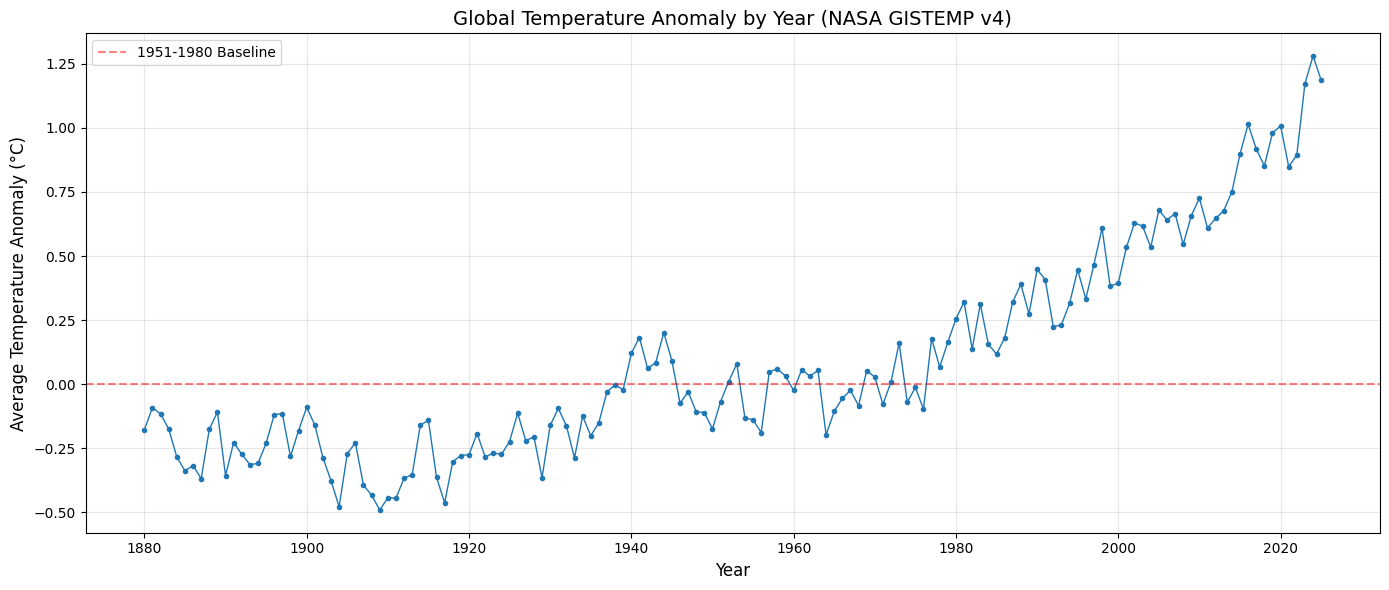

In [ ]:
# Visualize the trends using matplotlib
import matplotlib.pyplot as plt

# Convert to pandas for plotting
yearly_pandas = yearly_avg.toPandas()

plt.figure(figsize=(14, 6))
plt.plot(yearly_pandas["Year"], yearly_pandas["Avg_Temp"], marker='o', markersize=3, linewidth=1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Temperature Anomaly (°C)", fontsize=12)
plt.title("Global Temperature Anomaly by Year (NASA GISTEMP v4)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='1951-1980 Baseline')
plt.legend()
plt.tight_layout()
plt.show()

## 3.6 Working with Missing Data

In [ ]:
from pyspark.sql.functions import when, isnan, isnull

# Create a DataFrame with missing values
data_with_nulls = [
    ("A", 25, 50000.0),
    ("B", None, 60000.0),
    ("C", 35, None),
    ("D", None, None),
    ("E", 45, 80000.0)
]

df_nulls = spark.createDataFrame(data_with_nulls, ["name", "age", "salary"])
print("DataFrame with null values:")
df_nulls.show()

# Count nulls per column
print("Null counts per column:")
df_nulls.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_nulls.columns
]).show()

DataFrame with null values:
+----+----+-------+
|name| age| salary|
+----+----+-------+
|   A|  25|50000.0|
|   B|NULL|60000.0|
|   C|  35|   NULL|
|   D|NULL|   NULL|
|   E|  45|80000.0|
+----+----+-------+

Null counts per column:
+----+---+------+
|name|age|salary|
+----+---+------+
|   0|  2|     2|
+----+---+------+



In [ ]:
# Drop rows with any null values
print("Drop rows with any null:")
df_nulls.na.drop().show()

# Drop rows where specific columns are null
print("Drop rows where age is null:")
df_nulls.na.drop(subset=["age"]).show()

# Fill null values
print("Fill nulls with 0:")
df_nulls.na.fill(0).show()

# Fill with different values per column
print("Fill with specific values per column:")
df_nulls.na.fill({"age": 30, "salary": 50000.0}).show()

Drop rows with any null:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   E| 45|80000.0|
+----+---+-------+

Drop rows where age is null:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   C| 35|   NULL|
|   E| 45|80000.0|
+----+---+-------+

Fill nulls with 0:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   B|  0|60000.0|
|   C| 35|    0.0|
|   D|  0|    0.0|
|   E| 45|80000.0|
+----+---+-------+

Fill with specific values per column:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   B| 30|60000.0|
|   C| 35|50000.0|
|   D| 30|50000.0|
|   E| 45|80000.0|
+----+---+-------+



---
# Part 4: Spark SQL
---

## 4.1 Introduction to Spark SQL

Spark SQL allows you to query structured data using SQL syntax. This is particularly useful if you're already familiar with SQL or need to integrate with SQL-based tools.

**Advantages of Spark SQL:**
- Familiar SQL syntax for data analysts
- Automatic query optimization via Catalyst
- Integration with Hive and other data sources
- Mix SQL with DataFrame operations

---
# Part 4: Spark SQL
---

## 4.1 Introduction to Spark SQL

Spark SQL allows you to query structured data using SQL syntax. This is particularly useful if you're already familiar with SQL or need to integrate with SQL-based tools.

**Advantages of Spark SQL:**
- Familiar SQL syntax for data analysts
- Automatic query optimization via Catalyst
- Integration with Hive and other data sources
- Mix SQL with DataFrame operations

## 4.2 Creating Temporary Views

To use SQL queries, you first need to register your DataFrame as a temporary view.

In [ ]:
# Register the temperature DataFrame as a temporary view
temp_df_enhanced.createOrReplaceTempView("temperatures")

print("Temporary view 'temperatures' created successfully!")
print("\nAvailable columns:")
print(temp_df_enhanced.columns)

Temporary view 'temperatures' created successfully!

Available columns:
['Year', 'Month', 'Mean', 'Source', 'Mean_F', 'Decade', 'Season']


## 4.3 Writing SQL Queries

Once you have a temporary view, you can run SQL queries using `spark.sql()`.

In [ ]:
# Basic SELECT query
result = spark.sql("""
    SELECT Year, Month, Mean, Mean_F, Season
    FROM temperatures
    LIMIT 10
""")
result.show()

+----+-----+-----+------+------+
|Year|Month| Mean|Mean_F|Season|
+----+-----+-----+------+------+
|1880|    1|-0.19| 31.66|Winter|
|1880|    2|-0.25| 31.55|Winter|
|1880|    3| -0.1| 31.82|Spring|
|1880|    4|-0.17| 31.69|Spring|
|1880|    5|-0.11|  31.8|Spring|
|1880|    6|-0.22|  31.6|Summer|
|1880|    7|-0.19| 31.66|Summer|
|1880|    8|-0.11|  31.8|Summer|
|1880|    9|-0.15| 31.73|Autumn|
|1880|   10|-0.24| 31.57|Autumn|
+----+-----+-----+------+------+



In [ ]:
# Filtering with WHERE
high_temps = spark.sql("""
    SELECT Year, Month, Mean, Season, Decade
    FROM temperatures
    WHERE Mean > 1.0
    ORDER BY Mean DESC
    LIMIT 15
""")

print("Months with temperature anomaly > 1.0°C:")
high_temps.show()

Months with temperature anomaly > 1.0°C:
+----+-----+----+------+------+
|Year|Month|Mean|Season|Decade|
+----+-----+----+------+------+
|2023|    9|1.48|Autumn|  2020|
|2024|    2|1.44|Winter|  2020|
|2023|   11| 1.4|Autumn|  2020|
|2024|    3|1.39|Spring|  2020|
|2025|    1|1.38|Winter|  2020|
|2016|    2|1.37|Winter|  2010|
|2023|   12|1.37|Winter|  2020|
|2025|    3|1.36|Spring|  2020|
|2016|    3|1.35|Spring|  2010|
|2023|   10|1.34|Autumn|  2020|
|2024|   10|1.33|Autumn|  2020|
|2024|    4|1.31|Spring|  2020|
|2024|   11| 1.3|Autumn|  2020|
|2024|    8|1.29|Summer|  2020|
|2024|   12|1.27|Winter|  2020|
+----+-----+----+------+------+



In [ ]:
# Aggregation with GROUP BY
yearly_stats = spark.sql("""
    SELECT
        Year,
        ROUND(AVG(Mean), 4) as avg_temp,
        ROUND(MAX(Mean), 4) as max_temp,
        ROUND(MIN(Mean), 4) as min_temp,
        COUNT(*) as num_records
    FROM temperatures
    GROUP BY Year
    HAVING AVG(Mean) > 0.5
    ORDER BY avg_temp DESC
""")

print("Years with average temperature anomaly > 0.5°C:")
yearly_stats.show(20)

Years with average temperature anomaly > 0.5°C:
+----+--------+--------+--------+-----------+
|Year|avg_temp|max_temp|min_temp|num_records|
+----+--------+--------+--------+-----------+
|2024|  1.2808|    1.44|    1.15|         12|
|2025|  1.1867|    1.38|    1.02|         12|
|2023|  1.1733|    1.48|    0.88|         12|
|2016|  1.0142|    1.37|    0.81|         12|
|2020|  1.0083|    1.24|     0.8|         12|
|2019|    0.98|    1.17|    0.86|         12|
|2017|  0.9183|    1.17|    0.71|         12|
|2015|  0.8983|    1.17|    0.73|         12|
|2022|  0.8942|    1.05|    0.73|         12|
|2018|  0.8517|    1.02|    0.77|         12|
|2021|  0.8492|    0.99|    0.64|         12|
|2014|  0.7508|    0.88|    0.55|         12|
|2010|  0.7258|    0.92|    0.45|         12|
|2005|  0.6792|    0.76|     0.6|         12|
|2013|  0.6775|    0.83|    0.53|         12|
|2007|  0.6658|    1.02|     0.5|         12|
|2009|  0.6575|     0.8|    0.53|         12|
|2012|  0.6467|     0.8|    0.47

In [ ]:
# Aggregation by decade
warmest_per_decade = spark.sql("""
    SELECT
        Decade,
        ROUND(AVG(Mean), 4) as Avg_Temp,
        COUNT(*) as Num_Records,
        MIN(Year) as First_Year,
        MAX(Year) as Last_Year
    FROM temperatures
    GROUP BY Decade
    ORDER BY Decade
""")

print("Average temperature anomaly by decade:")
warmest_per_decade.show()

Average temperature anomaly by decade:
+------+--------+-----------+----------+---------+
|Decade|Avg_Temp|Num_Records|First_Year|Last_Year|
+------+--------+-----------+----------+---------+
|  1880| -0.2158|        120|      1880|     1889|
|  1890| -0.2414|        120|      1890|     1899|
|  1900| -0.3216|        120|      1900|     1909|
|  1910| -0.3322|        120|      1910|     1919|
|  1920| -0.2428|        120|      1920|     1929|
|  1930|  -0.124|        120|      1930|     1939|
|  1940|  0.0413|        120|      1940|     1949|
|  1950| -0.0477|        120|      1950|     1959|
|  1960| -0.0301|        120|      1960|     1969|
|  1970|  0.0344|        120|      1970|     1979|
|  1980|  0.2462|        120|      1980|     1989|
|  1990|  0.3863|        120|      1990|     1999|
|  2000|  0.5896|        120|      2000|     2009|
|  2010|  0.8072|        120|      2010|     2019|
|  2020|  1.0654|         72|      2020|     2025|
+------+--------+-----------+----------+---

## 4.4 Combining DataFrame API and SQL

You can seamlessly switch between DataFrame API and SQL operations.

In [ ]:
# Start with SQL, continue with DataFrame API
recent_years = spark.sql("""
    SELECT *
    FROM temperatures
    WHERE Year >= 2000
""")

# Continue with DataFrame operations
monthly_pattern = recent_years \
    .groupBy("Month") \
    .agg(
        round(avg("Mean"), 4).alias("Avg_Temp"),
        count("*").alias("Count")
    ) \
    .orderBy("Month")

print("Monthly temperature patterns (2000+):")
monthly_pattern.show(12)

Monthly temperature patterns (2000+):
+-----+--------+-----+
|Month|Avg_Temp|Count|
+-----+--------+-----+
|    1|  0.7892|   26|
|    2|  0.7954|   26|
|    3|  0.8773|   26|
|    4|  0.7823|   26|
|    5|  0.7377|   26|
|    6|  0.7219|   26|
|    7|    0.73|   26|
|    8|  0.7662|   26|
|    9|  0.7892|   26|
|   10|  0.8162|   26|
|   11|   0.825|   26|
|   12|  0.7669|   26|
+-----+--------+-----+



In [ ]:
# The result of DataFrame operations can be registered as a new view
monthly_pattern.createOrReplaceTempView("monthly_patterns")

# Query the new view
warmest_months = spark.sql("""
    SELECT
        Month,
        Avg_Temp,
        CASE
            WHEN Month IN (12, 1, 2) THEN 'Winter'
            WHEN Month IN (3, 4, 5) THEN 'Spring'
            WHEN Month IN (6, 7, 8) THEN 'Summer'
            ELSE 'Autumn'
        END as Season
    FROM monthly_patterns
    ORDER BY Avg_Temp DESC
""")

warmest_months.show()

+-----+--------+------+
|Month|Avg_Temp|Season|
+-----+--------+------+
|    3|  0.8773|Spring|
|   11|   0.825|Autumn|
|   10|  0.8162|Autumn|
|    2|  0.7954|Winter|
|    1|  0.7892|Winter|
|    9|  0.7892|Autumn|
|    4|  0.7823|Spring|
|   12|  0.7669|Winter|
|    8|  0.7662|Summer|
|    5|  0.7377|Spring|
|    7|    0.73|Summer|
|    6|  0.7219|Summer|
+-----+--------+------+



---
# Part 5: Practical Exercises
---

Now it's your turn to apply what you've learned! Complete the following exercises using the datasets provided.

## Exercise 1: Movie Ratings Analysis

Let's work with a real dataset! We'll use the MovieLens 100K dataset, which contains 100,000 movie ratings.

In [ ]:
# Download MovieLens 100K dataset
!wget -q https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q -o ml-100k.zip

# Load the ratings data
ratings_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)
])

ratings_df = spark.read \
    .option("delimiter", "\t") \
    .schema(ratings_schema) \
    .csv("ml-100k/u.data")

# Load movie titles
movies_df = spark.read \
    .option("delimiter", "|") \
    .csv("ml-100k/u.item") \
    .select(
        col("_c0").cast("int").alias("movie_id"),
        col("_c1").alias("title"),
        col("_c2").alias("release_date")
    )

print("Ratings DataFrame:")
ratings_df.show(5)

print("\nMovies DataFrame:")
movies_df.show(5)

# Register as views for SQL
ratings_df.createOrReplaceTempView("ratings")
movies_df.createOrReplaceTempView("movies")

Ratings DataFrame:
+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
+-------+--------+------+---------+
only showing top 5 rows

Movies DataFrame:
+--------+-----------------+------------+
|movie_id|            title|release_date|
+--------+-----------------+------------+
|       1| Toy Story (1995)| 01-Jan-1995|
|       2| GoldenEye (1995)| 01-Jan-1995|
|       3|Four Rooms (1995)| 01-Jan-1995|
|       4|Get Shorty (1995)| 01-Jan-1995|
|       5|   Copycat (1995)| 01-Jan-1995|
+--------+-----------------+------------+
only showing top 5 rows


### Task 1.1: Basic Statistics

Calculate and display:
1. Total number of ratings
2. Number of unique users
3. Number of unique movies
4. Average rating across all movies

In [58]:
from pyspark.sql import functions as F

basic_stats = ratings_df.agg(
    F.count("*").alias("total_ratings"),
    F.count_distinct("user_id").alias("unique_users"),
    F.count_distinct("movie_id").alias("unique_movies"),  # Fixed the alias here
    F.round(F.avg("rating"), 4).alias("average_rating")
)
print("Basic Statistics: ")
basic_stats.show()

Basic Statistics: 
+-------------+------------+-------------+--------------+
|total_ratings|unique_users|unique_movies|average_rating|
+-------------+------------+-------------+--------------+
|       100000|         943|         1682|        3.5299|
+-------------+------------+-------------+--------------+



In [64]:

from pyspark.sql.functions import count, countDistinct, round, avg
basic_stats = ratings_df.agg(
    count("*").alias("total_ratings"),
    countDistinct("user_id").alias("unique_users"),
    countDistinct("movie_id").alias("unique_users"),
    round(avg("rating"), 4).alias("average_rating")
)

basic_stats.show()

+-------------+------------+------------+--------------+
|total_ratings|unique_users|unique_users|average_rating|
+-------------+------------+------------+--------------+
|       100000|         943|        1682|        3.5299|
+-------------+------------+------------+--------------+



### Task 1.2: Rating Distribution

Show the distribution of ratings (how many ratings of each value 1-5). Order by rating value.

In [70]:
distribution = ratings_df.groupBy("rating") \
  .agg(count("*").alias("count")).orderBy("rating")

distribution.show()

+------+-----+
|rating|count|
+------+-----+
|     1| 6110|
|     2|11370|
|     3|27145|
|     4|34174|
|     5|21201|
+------+-----+



### Task 1.3: Top Rated Movies

Find the top 10 highest-rated movies that have at least 100 ratings. Join with the movies table to show the movie title.

**Hint:** You'll need to:
1. Group ratings by movie_id
2. Calculate average rating and count
3. Filter for movies with ≥100 ratings
4. Join with movies_df to get titles
5. Order by average rating (descending)

In [81]:
top_rated_movies = ratings_df.groupBy("movie_id")\
.agg(
    count("*").alias("number_of_ratings"),
    round(avg("rating"), 2).alias("avg_rating"),
)

movies_hundred = top_rated_movies.filter(col("number_of_ratings")>=100)

top_ten = movies_hundred\
.join(movies_df, "movie_id")\
.select("title", "avg_rating", "number_of_ratings") \
.orderBy(col("avg_rating").desc())\
.limit(10)

top_ten.show(truncate=False)

+--------------------------------------+----------+-----------------+
|title                                 |avg_rating|number_of_ratings|
+--------------------------------------+----------+-----------------+
|Close Shave, A (1995)                 |4.49      |112              |
|Schindler's List (1993)               |4.47      |298              |
|Wrong Trousers, The (1993)            |4.47      |118              |
|Casablanca (1942)                     |4.46      |243              |
|Shawshank Redemption, The (1994)      |4.45      |283              |
|Usual Suspects, The (1995)            |4.39      |267              |
|Rear Window (1954)                    |4.39      |209              |
|Star Wars (1977)                      |4.36      |583              |
|12 Angry Men (1957)                   |4.34      |125              |
|One Flew Over the Cuckoo's Nest (1975)|4.29      |264              |
+--------------------------------------+----------+-----------------+

